In [16]:
import numpy as np

## Temperature to velocities

In [106]:
h = []

In [119]:
d = 1
n = 10
m = np.ones((n, 1))
Reduced_Temp = 1
Multiplier = 119.8
T = Reduced_Temp * Multiplier

In [120]:
def generate_velocities(number_particles, system_dimension, masses, temperature):
    import math
    while(len(h) < number_particles * system_dimension):
        r2 = 0
        while r2 >= 1 or r2 == 0:
            x = 2 * random.uniform(0, 1) - 1
            y = 2 * random.uniform(0, 1) - 1
            r2 = x**2 + y**2
        mult = math.sqrt(- 2 * math.log(r2) / r2)
        h.extend([x*mult, y*mult])
    vels = np.array(h).reshape(-1, 1).astype('float32')
    scaledvels = vels * np.sqrt(BOLTZ * temperature / masses)
    return scaledvels

In [121]:
returned_vels = generate_velocities(n, d, m, T)

In [122]:
print(returned_vels)

[[-0.27614507]
 [ 0.02306323]
 [ 0.10312074]
 [-0.33503203]
 [ 0.917675  ]
 [ 1.46087223]
 [ 1.41470864]
 [-0.13811514]
 [ 0.47832298]
 [ 1.66875018]]


## Generating the potential energy function from Frenkel

In [5]:
def pot_energy(x):
    rv = 1e5
    if x >= -2 and x <= -1.25:
        rv = 1 + np.sin(2 * np.pi * x)
    
    if x >= -1.25 and x <= -0.25:
        rv = 2 * (1 + np.sin(2 * np.pi * x))
        
    if x >= -0.25 and x <= 0.75:
        rv = 3 * (1 + np.sin(2 * np.pi * x))
                  
    if x >= 0.75 and x <= 1.75:
        rv = 4 * (1 + np.sin(2 * np.pi * x))
                  
    if x >= 1.75 and x <= 2:
        rv = 5 * (1 + np.sin(2 * np.pi * x))
                  
    return rv

In [6]:
x = np.linspace(-5, 5, 1000)
U = np.array(list(map(pot_energy, x)))


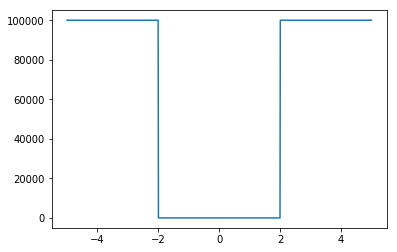

In [7]:
plt.plot(x, U)

## Generating the force function

In [9]:
def force(x):
    lorge = 1e2
    if x < -2:
        return lorge
    if x > 2:
        return -1 * lorge
    rv = 0
    if x >= -2 and x <= -1.25:
        rv = -2 * np.pi * np.cos(2 * np.pi * x)
    
    if x >= -1.25 and x <= -0.25:
        rv = -4 * np.pi * np.cos(2 * np.pi * x)
        
    if x >= -0.25 and x <= 0.75:
        rv = -6 * np.pi * np.cos(2 * np.pi * x)
                  
    if x >= 0.75 and x <= 1.75:
        rv = -8 * np.pi * np.cos(2 * np.pi * x)
        
    if x >= 1.75 and x <= 2:
        rv = -10 * np.pi * np.cos(2 * np.pi * x)
                  
    return rv

In [10]:
f = np.array(list(map(force, x)))

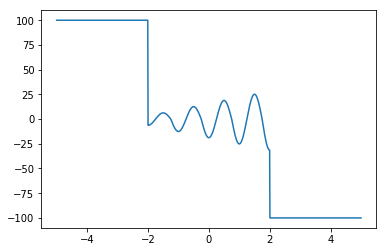

In [11]:
plt.plot(x, f)

## Integrator : Simulating NVE dynamics for the PE function for 1 particle

In [12]:
def step(x, v, dt = 0.001, m = 1):
    f = force(x)
    x_new = x + dt * v + dt * dt * f / (2 * m)
    f_new = force(x_new)
    v_new = v + dt * (f + f_new) / (2 * m)
    return x_new, v_new

In [13]:
x = 1.0
v = 0.01
no_of_steps = 10000

In [14]:
pos = []
vel = []
pos.append(x)
vel.append(v)

In [81]:
for t in range(no_of_steps):
    x_new, v_new = step(x, v)
    x, v = x_new, v_new
    pos.append(x)
    vel.append(v_new)

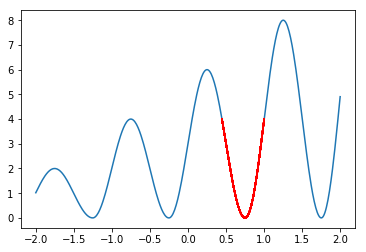

In [82]:
x_axis = np.linspace(-5, 5, 1000)
plt.plot(x_axis, U)
U_all = np.array(list(map(pot_energy, pos)))
plt.plot(pos, U_all, color='red')

## Coorelating Temperature into the system : Andersen Thermostat

### Initialization of system

In [168]:
T = 2.0

In [201]:
n_p = 108
dt = 1e-4

In [202]:
x_range = np.linspace(-1.7, 1.7, 1000)
req_shape = (n_p, 1)
x = np.random.choice(x_range, req_shape)
v = np.random.random(req_shape) - 0.5

In [203]:
m = np.ones(req_shape)
v_com = np.sum(m * v, axis = 0) / np.sum(m)

In [204]:
KE = np.sum(m * v**2) / 2

In [205]:
scaling_factor = np.sqrt(3 * T / (KE * n_p))
v = (v - v_com) * scaling_factor

In [206]:
force_t = np.array(list(map(force, x)))

In [207]:
def integrate(switch, x, v, f, temp, nu = 0.01):
    if switch == 1:
        x_new = x + dt * v + (f / m) * dt * dt / 2
        v_new = v + dt * (f / (2 * m))
    elif switch == 2:
        v_new = v + dt * (f / (2 * m))
        KE = m * (v_new ** 2)
        sigma = np.sqrt(temp)
        probs = np.random.random(size = (n_p, 1))
        g = np.random.normal(0, sigma, n_p).reshape(-1, 1)
        ind = probs < nu * dt
        if ind.any():
            print("Gaussian velocity replaced")
        v_new = (probs > nu * dt) * v  + (probs < nu * dt) * g
        x_new = x
    return x_new, v_new
        

In [208]:
x_new, v_new = integrate(1, x, v, force_t, T)
f_new = np.array(list(map(force, x_new)))
x_new, v_new = integrate(2, x_new, v_new, f_new, T)

Text(0.5, 1.0, 'Initial starting positions')

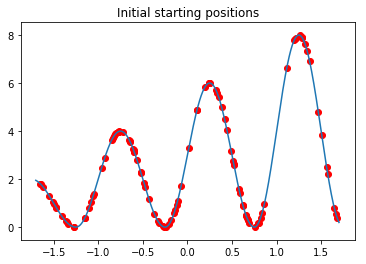

In [209]:
U = np.array(list(map(pot_energy, x_range)))
plt.plot(x_range, U)
U_x = np.array(list(map(pot_energy, x)))
plt.scatter(x, U_x, color = 'red')
plt.title("Initial starting positions")

### Running a simulation of Andersen Thermostat for nsteps = 10000

In [210]:
nstep = 10000
outFreq = 100

In [211]:
vels = v

In [212]:
for step in range(1, nstep + 1):
    x_n, v_n = integrate(1, x, v, force_t, T)
    f_n = np.array(list(map(force, x_new)))
    x_n, v_n = integrate(2, x_n, v_n, f_n, T)
#     print(np.linalg.norm(x_n - x))
    if step % outFreq:
        vels = np.hstack((vels, v))
    x, v = x_n, v_n


Gaussian velocity replaced
Gaussian velocity replaced


In [213]:
def hist(vels):
    h = np.around(vels, 2)
    vel_vals, vel_count = np.unique(h, return_counts = True)
    return vel_vals, (vel_count / vel_count.sum())

In [214]:
b_x, b_y = hist(vels)

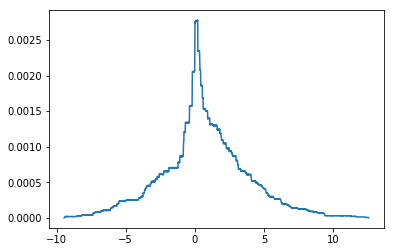

In [215]:
plt.plot(b_x, b_y)

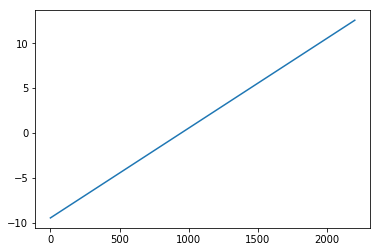

In [216]:
plt.plot(x)